In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import sys
import seaborn as sns
import matplotlib.ticker as mtick


In [3]:
regions = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/counts/decoy_known_locations.txt',  
                                   delimiter='\t', header=None, names=['name', 'pos'], usecols=[1,2])#, nrows=100000, skiprows=600000)#len(regions_ground_truth))

# Known Alt Haps

In [9]:
regions_ground_truth = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/counts/decoy_known_locations.txt',  
                                   delimiter='\t', header=None, names=['name', 'pos'], usecols=[1,2])#, nrows=100000, skiprows=600000)#len(regions_ground_truth))
prevs = np.loadtxt('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/counts/decoy_known_prevs.txt')
abundances = np.loadtxt('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/counts/decoy_known_abundances.txt')

regions_predicted = pd.read_table(#'/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/localize/ground_truth/localized_006.txt',
    '/home/groups/dpwall/briannac/alt_haplotypes/results/approximate_regions/localized_decoy_known.tsv',
                                   names = 
                                           ['chrom_pred1','start_pred1','end_pred1',
                                            'chrom_pred5','start_pred5','end_pred5',
                                            'chrom_pred10','start_pred10','end_pred10',
                                            'chrom_pred25','start_pred25','end_pred25',
                                            'chrom_pred50',  'start_pred50', 'end_pred50',
                                            'chrom_pred100',  'start_pred100',  'end_pred100'], delimiter='\t',
                                   comment='#', header=None, nrows=len(regions_ground_truth))
#regions_ground_truth = regions_ground_truth.replace(2323, 23).replace(2424,24)
regions_predicted['start_true'] = [int(r.split(':')[-1].split('-')[0]) for r in regions_ground_truth['pos']]
regions_predicted['end_true'] = [int(r.split(':')[-1].split('-')[1]) for r in regions_ground_truth['pos']]
regions_predicted['chrom_true'] = [r.split(':')[0].replace('chr','') for r in regions_ground_truth['pos']]
regions_predicted['hap_name'] = regions_ground_truth['name']
regions_predicted['prevalence'] = prevs
regions_predicted['abundance'] = abundances
for c in regions_predicted.columns:
    if 'chrom_pred' in c:
        regions_predicted[c] = [str(int(i)).replace('23', 'X').replace('24', 'Y') if ~np.isnan(i) else 'NaN' for i in regions_predicted[c]]



 1
unlocalized:  0.006626394457033293
localized:  0.9933736055429667
correct:  0.6325796365696357
correct_chrom out of inccorect:  0.7828673229059726
median distance from true: 349265.0
incorrect:  0.360793968973331
accuracy:  0.636799320054286
med length: 101499.0


 5
unlocalized:  0.03564036081575737
localized:  0.9643596391842426
correct:  0.8162557739236534
correct_chrom out of inccorect:  0.6428400669376045
median distance from true: 586024.0
incorrect:  0.14810386526058916
accuracy:  0.8464225800803203
med length: 579716.0


 10
unlocalized:  0.05731436290744291
localized:  0.942685637092557
correct:  0.8716445877636395
correct_chrom out of inccorect:  0.5001150130348107
median distance from true: 1354443.0
incorrect:  0.07104104932891755
accuracy:  0.9246397244918007
med length: 1299993.0


 25
unlocalized:  0.09297923566323862
localized:  0.9070207643367614
correct:  0.8846195746906048
correct_chrom out of inccorect:  0.49811550151975686
median distance from true: 3798504.0


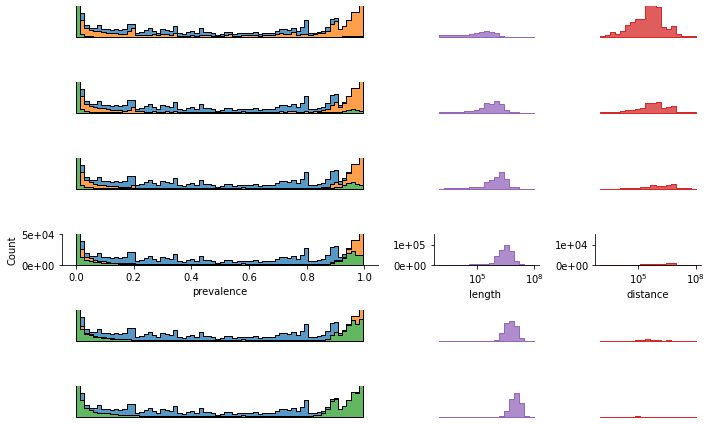

In [10]:
fig, ax = plt.subplots(nrows=6, ncols=3,figsize=(10,6),gridspec_kw={'width_ratios': [3, 1,1]})
for i, std_float in enumerate([1, 5, 10, 25, 50, 100]):
    std = str(std_float)
    print('\n\n', std)
    df = regions_predicted.copy()
    df = df [['hap_name', 'chrom_true', 'start_true', 'end_true', 'prevalence', 'chrom_pred%s' % std, 'start_pred%s' % std, 'end_pred%s' % std]]
    df.columns = ['hap_name', 'chrom_true', 'start_true', 'end_true', 'prevalence', 'chrom_pred', 'start_pred', 'end_pred']
    

    unlocalized = df[(df['chrom_pred'])=='NaN'].copy()
    unlocalized['status'] = 'unlocalized'
    localized = df[(df['chrom_pred'])!='NaN'].copy()

    correct = localized[(localized.chrom_true==localized['chrom_pred']) & 
          (localized['end_pred']>=localized.start_true) & (localized['start_pred']<=localized.end_true)].copy()
    correct['status'] = 'correct'
    incorrect = localized[~((localized.chrom_true==localized['chrom_pred']) & 
                          (localized['end_pred']>=localized.start_true) & 
                          (localized['start_pred']<=localized.end_true))].copy()
    incorrect['status'] = 'incorrect'

    new_df = pd.concat([correct, incorrect, unlocalized])
    new_df['length'] = new_df['end_pred']-new_df['start_pred']
    g = sns.histplot(new_df, x='prevalence', hue='status',  element='step', multiple='stack', hue_order=['correct', 'incorrect', 'unlocalized'], ax=ax[i,0], legend=False)
    ax[i,0].set_ylim(0,50000)
    ax[i,0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

    # Compute some metrics on subsection of dataframe.
    new_df = new_df[(new_df.prevalence>.2) & (new_df.prevalence<.8)]
    
    # Histograms of lengths for sensitivity
    sns.histplot(data=new_df[new_df.status=='correct'], x='length', element='step', bins=np.linspace(3,8,20), log_scale=True, ax=ax[i,1], color=sns.color_palette()[4], legend=False)
    ax[i,1].set_ylim(0,150000)
    ax[i,1].set_xlabel('length ')
    ax[i,1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

    
    
    # Distance from true value for incorrect
    right_chrom_wrong_loci = new_df[((new_df.chrom_pred!='NaN')) & (new_df.chrom_true==new_df['chrom_pred'])]
    new_df['distance'] = [2e20 if chrom_pred!=chrom_true else max(d1, d2) for d1, d2, chrom_pred, chrom_true in zip(new_df['start_true']-new_df['end_pred'], 
                                                      new_df['start_pred']-new_df['end_true'], new_df['chrom_pred'], new_df['chrom_true'])]
    sns.histplot(data=new_df[new_df.status=='incorrect'], x='distance', element='step', bins=np.linspace(3,8,20), log_scale=True, color=sns.color_palette()[3], ax=ax[i,2], legend=False)
    ax[i,2].set_ylim(0,15000)
    ax[i,2].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
    
    
    for a in [0,1,2]:
        ax[i,a].spines["right"].set_visible(False)
        ax[i,a].spines["top"].set_visible(False)
        if a>0: ax[i,a].set_ylabel('')
    
    if i!=3:
        for a in [0,1,2]:
            ax[i,a].set_ylabel('')
            ax[i,a].set_xlabel('')
            ax[i,a].spines["bottom"].set_visible(False)
            ax[i,a].spines["left"].set_visible(False)
            ax[i,a].set_xticks([])
            ax[i,a].set_yticks([])
    
            

        
        
  

    print('unlocalized: ', np.mean(new_df.status=='unlocalized'))
    print('localized: ', np.mean(new_df.status!='unlocalized'))

    print('correct: ', np.mean(new_df.status=='correct'))
    print('correct_chrom out of inccorect: ', (np.sum((new_df.status=='incorrect') & (new_df.chrom_pred==new_df.chrom_true)))/np.sum(new_df.status=='incorrect'))
    print('median distance from true:', np.median(new_df[(new_df.chrom_pred==new_df.chrom_true) & (new_df.status=='incorrect')]['distance']))
    print('incorrect: ', np.mean(new_df.status=='incorrect'))
    print('accuracy: ', np.sum(new_df.status=='correct')/np.sum(new_df.status!='unlocalized'))
    print('med length:', np.median(new_df[new_df.status=='correct']['end_pred']-new_df[new_df.status=='correct']['start_pred']))
plt.tight_layout()
#plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/known_alt_haps_stats.svg', transparent=True, bbox_inches='tight',pad_inches = 0)
plt.show()



 10


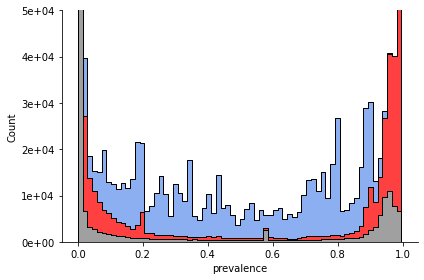

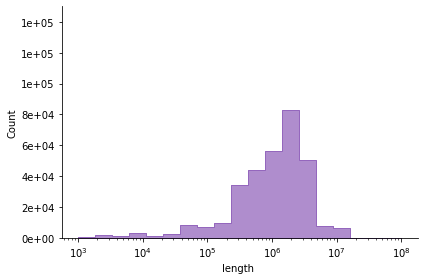

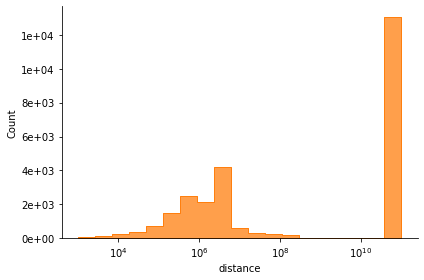

unlocalized:  0.05731436290744291
localized:  0.942685637092557
correct:  0.8716445877636395
correct_chrom out of inccorect:  0.5001150130348107
median distance from true: 1354443.0
incorrect:  0.07104104932891755
accuracy:  0.9246397244918007
med length: 1299993.0


In [49]:
for i, std_float in enumerate([10]):
    std = str(std_float)
    print('\n\n', std)
    df = regions_predicted.copy()
    df = df [['hap_name', 'chrom_true', 'start_true', 'end_true', 'prevalence', 'chrom_pred%s' % std, 'start_pred%s' % std, 'end_pred%s' % std]]
    df.columns = ['hap_name', 'chrom_true', 'start_true', 'end_true', 'prevalence', 'chrom_pred', 'start_pred', 'end_pred']
    

    unlocalized = df[(df['chrom_pred'])=='NaN'].copy()
    unlocalized['status'] = 'unlocalized'
    localized = df[(df['chrom_pred'])!='NaN'].copy()

    correct = localized[(localized.chrom_true==localized['chrom_pred']) & 
          (localized['end_pred']>=localized.start_true) & (localized['start_pred']<=localized.end_true)].copy()
    correct['status'] = 'correct'
    incorrect = localized[~((localized.chrom_true==localized['chrom_pred']) & 
                          (localized['end_pred']>=localized.start_true) & 
                          (localized['start_pred']<=localized.end_true))].copy()
    incorrect['status'] = 'incorrect'

    new_df = pd.concat([correct, incorrect, unlocalized])
    new_df['length'] = new_df['end_pred']-new_df['start_pred']
    fig, ax = plt.subplots()
    g = sns.histplot(new_df, x='prevalence', hue='status',  element='step', multiple='stack', hue_order=['correct', 'incorrect', 'unlocalized'], ax=ax, legend=False, palette=['cornflowerblue', 'red', 'grey'])
    ax.set_ylim(0,50000)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.tight_layout()
    plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/decoy/decoy_performance.svg', transparent=True, bbox_inches='tight',pad_inches = 0)
    plt.show()
    
    
    # Compute some metrics on subsection of dataframe.
    new_df = new_df[(new_df.prevalence>.2) & (new_df.prevalence<.8)]
    
    # Histograms of lengths for sensitivity
    fig, ax = plt.subplots()
    sns.histplot(data=new_df[new_df.status=='correct'], x='length', element='step', bins=np.linspace(3,8,20), log_scale=True, ax=ax, color=[sns.color_palette()[4]], legend=False)
    ax.set_ylim(0,150000)
    ax.set_xlabel('length ')
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.tight_layout()
    plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/decoy/decoy_region_length.svg', transparent=True, bbox_inches='tight',pad_inches = 0)
    plt.show()
    
    # Distance from true value for incorrect
    right_chrom_wrong_loci = new_df[((new_df.chrom_pred!='NaN')) & (new_df.chrom_true==new_df['chrom_pred'])]
    new_df['distance'] = [1e11 if chrom_pred!=chrom_true else max(d1, d2) for d1, d2, chrom_pred, chrom_true in zip(new_df['start_true']-new_df['end_pred'], 
                                                      new_df['start_pred']-new_df['end_true'], new_df['chrom_pred'], new_df['chrom_true'])]
    fig, ax = plt.subplots()
    sns.histplot(data=new_df[new_df.status=='incorrect'], x='distance', element='step', bins=np.linspace(3,11,20), log_scale=True, color=sns.color_palette()[1], ax=ax, legend=False)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.tight_layout()
    plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/decoy/decoy_distance.svg', transparent=True, bbox_inches='tight',pad_inches = 0)
    plt.show()

    print('unlocalized: ', np.mean(new_df.status=='unlocalized'))
    print('localized: ', np.mean(new_df.status!='unlocalized'))

    print('correct: ', np.mean(new_df.status=='correct'))
    print('correct_chrom out of inccorect: ', (np.sum((new_df.status=='incorrect') & (new_df.chrom_pred==new_df.chrom_true)))/np.sum(new_df.status=='incorrect'))
    print('median distance from true:', np.median(new_df[(new_df.chrom_pred==new_df.chrom_true) & (new_df.status=='incorrect')]['distance']))
    print('incorrect: ', np.mean(new_df.status=='incorrect'))
    print('accuracy: ', np.sum(new_df.status=='correct')/np.sum(new_df.status!='unlocalized'))
    print('med length:', np.median(new_df[new_df.status=='correct']['end_pred']-new_df[new_df.status=='correct']['start_pred']))


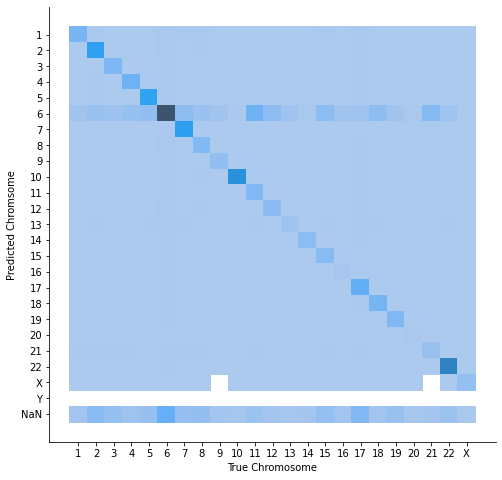

In [32]:
pred_locs['chrom_pred10'] = [str(i).replace('XX', 'X').replace('YY', 'Y') for i in pred_locs['chrom_pred10']]
pred_locs['chrom_pred10'] = pd.Categorical(pred_locs['chrom_pred10'], categories=[str(i) for i in range(1,23)] + ['X', 'Y', 'NaN'], ordered=True)
true_locs['chrom'] = [str(i).replace('XX', 'X').replace('YY', 'Y') for i in true_locs['chrom_true']]
true_locs['chrom'] = pd.Categorical(true_locs['chrom_true'], categories=[str(i) for i in range(1,23)] + ['X', 'Y', 'NaN'], ordered=True)

f,ax = plt.subplots(figsize=(8,8))
sns.histplot(y=pred_locs['chrom_pred10'], x=true_locs['chrom_true'], ax=ax)
ax.set_ylabel('Predicted Chromsome')
ax.set_xlabel('True Chromosome')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/decoy/chrom_confusion.svg', transparent=True)
plt.show()

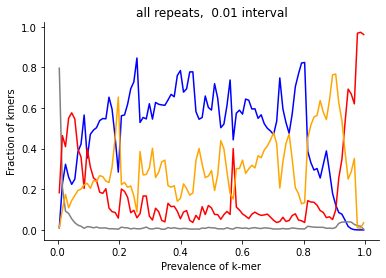

131810.0 0.8669881554757446 0.537375163098335


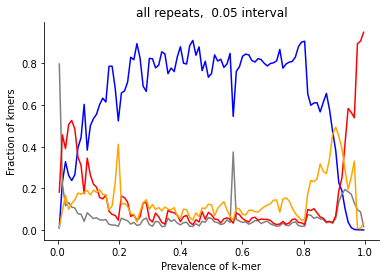

738802.0 0.8401586858895915 0.6953272136034144


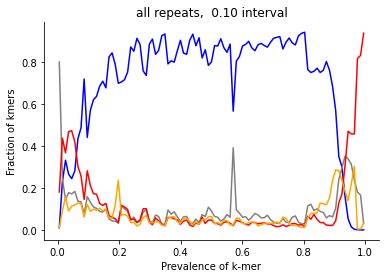

1597140.0 0.8155589579550694 0.7741733431969181


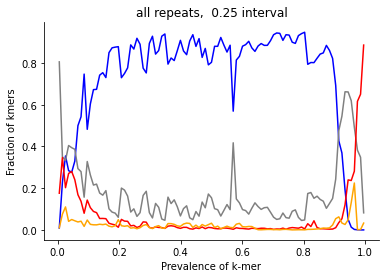

3822734.0 0.7563135696925888 0.8644161229389143


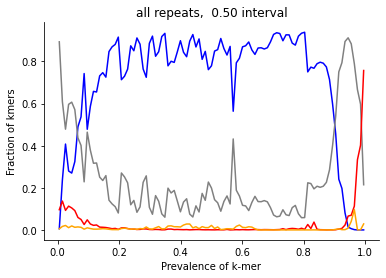

7237352.0 0.6895835349160183 0.9408113573521522


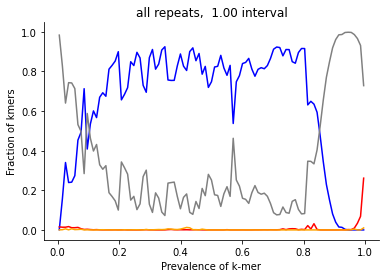

11881641.0 0.6253735208574047 0.9905118374498003


In [21]:
pred_locs_all = regions_predicted
true_locs_all = regions_predicted
true_locs_all['prev'] = true_locs_all.prevalence
if True:
    for i in [1,5,10,25,50,100]:
        pred_locs = pred_locs_all
        true_locs = true_locs_all

        bins = np.linspace(0,1, 100)
        freq_correct, _ = np.histogram(true_locs[(
            (pred_locs['chrom_pred%s' % str(i)]==true_locs['chrom_true']) & 
            (pred_locs['start_pred%s' % str(i)] <= true_locs.end_true) & 
            (pred_locs['end_pred%s' % str(i)] >= true_locs.start_true))].prev, bins=bins)
        freq, _ = np.histogram(true_locs.prev, bins=bins)

        freq_nan, _ = np.histogram(true_locs[
            (pred_locs['chrom_pred%s' % str(i)]=='NaN')].prev, bins=bins)
        freq_not_nan, _ = np.histogram(true_locs[
            (pred_locs['chrom_pred%s' % str(i)]=='NaN')].prev, bins=bins)
        freq_wrong_chrom, _ = np.histogram(true_locs[(
            pred_locs['chrom_pred%s' % str(i)]!=true_locs['chrom_true'])].prev, bins=bins)
        freq_wrong_chrom = freq_wrong_chrom - freq_nan
        freq_wrong_id = freq - freq_nan - freq_correct - freq_wrong_chrom
        f,ax = plt.subplots()
        ax.plot((bins[1:]+bins[:-1])/2, freq_correct/freq, label='correct region', color='blue')
        ax.plot((bins[1:]+bins[:-1])/2, freq_nan/freq, label='unable to localize', color='grey')
        ax.plot((bins[1:]+bins[:-1])/2, freq_wrong_chrom/freq, label='incorrect chromsome', color='red')
        ax.plot((bins[1:]+bins[:-1])/2, freq_wrong_id/freq, label='right chromomsome, incorrect region', color='orange')
        #plt.legend()
        ax.set_ylabel('Fraction of kmers')
        ax.set_xlabel('Prevalence of k-mer')
        ax.set_title('all repeats,  %.02f interval' % (i/100))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/decoy/performance_%.02f_interval.svg' % (
            i/100), transparent=True)
        plt.show()
        correct_locs_pred = pred_locs[(
            (pred_locs['chrom_pred%s' % str(i)]==true_locs['chrom_true']) & 
            (pred_locs['start_pred%s' % str(i)] <= true_locs.end_true) & 
            (pred_locs['end_pred%s' % str(i)] >= true_locs.start_true))]
        print(np.median((correct_locs_pred['end_pred%s'%i]-correct_locs_pred['start_pred%s'%i])),
             len(true_locs[(true_locs.prev<.8) &
            (pred_locs['chrom_pred%s' % str(i)]!='NaN')])/sum(true_locs.prev<.8),
             len(true_locs[(true_locs.prev<.8) &
            (pred_locs['chrom_pred%s' % str(i)]==true_locs['chrom_true']) & 
            (pred_locs['start_pred%s' % str(i)] <= true_locs.end_true) & 
            (pred_locs['end_pred%s' % str(i)] >= true_locs.start_true)])/sum((true_locs.prev<.8) & (pred_locs['chrom_pred%s' % str(i)]!='NaN')))

In [73]:
new_df.chrom_true = ['%.02d'% int(c) if (c[0] in [str(i) for i in range(10)]) else c for c  in new_df.chrom_true]
correct_vals = new_df[new_df.status=='correct'].sort_values(['chrom_true', 'hap_name']).groupby(['chrom_true', 'hap_name']).count()[['start_true']]
incorrect_vals = new_df[new_df.status=='incorrect'].sort_values(['chrom_true', 'hap_name']).groupby(['chrom_true', 'hap_name']).count()[['start_true']]
unlocalized_vals = new_df[new_df.status=='unlocalized'].sort_values(['chrom_true', 'hap_name']).groupby(['chrom_true', 'hap_name']).count()[['start_true']]



In [78]:
bar_df = pd.concat([correct_vals, incorrect_vals, unlocalized_vals], axis=1)
bar_df[pd.isna(bar_df)] = 0
bar_df.columns = ['correct', 'incorrect','unlocalized']
bar_df= bar_df.apply(lambda x: x/sum(x), axis=1)
labels = [i[1] for i in bar_df.index]
correct = bar_df.correct.values
incorrect = bar_df.incorrect.values
unlocalized = bar_df.unlocalized.values


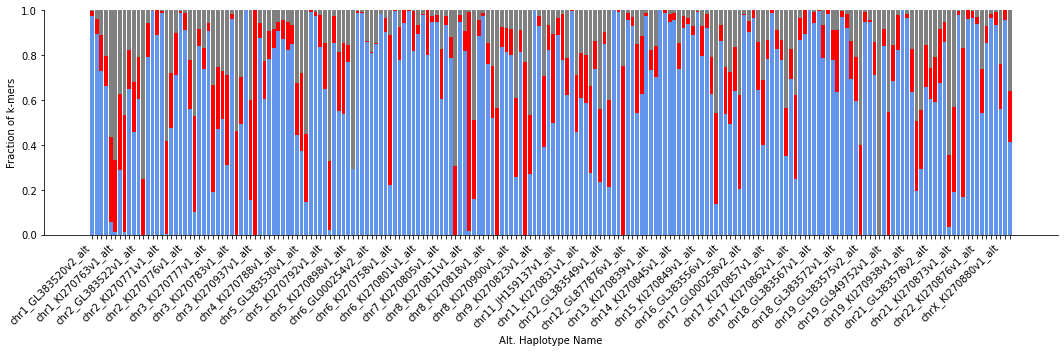

In [117]:
f, ax = plt.subplots(figsize=(15,5))
ax.bar(labels, correct, label='correct', color='cornflowerblue')
ax.bar(labels, unlocalized, label='unlocalized', bottom = correct+incorrect, color='grey')
ax.bar(labels, incorrect, label='incorrect', bottom = correct, color='red')

for i, t in enumerate(ax.get_xticklabels()):
    if (i % 5) != 0:
        t.set_visible(False)
plt.xlabel('Alt. Haplotype Name')
plt.ylabel('Fraction of k-mers')
plt.xticks(rotation=45, ha='right')
#plt.yscale('symlog', linthresh=10000)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/decoy/hap_names_relative_performance.svg', transparent=True)
plt.show()


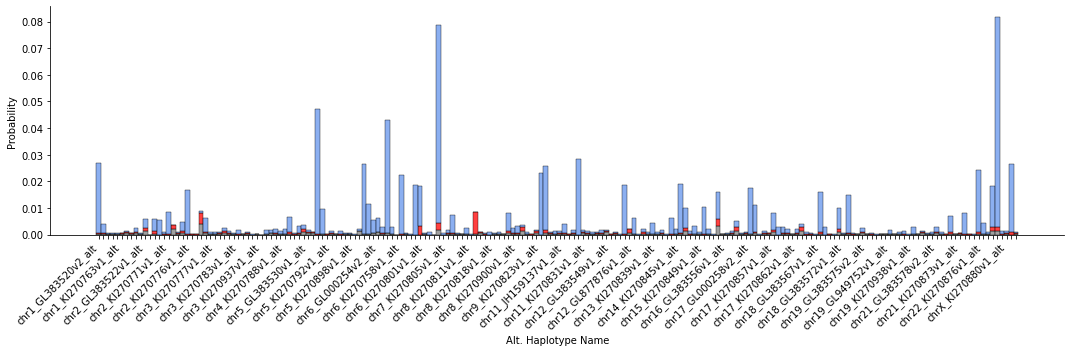

In [118]:
f, ax = plt.subplots(figsize=(15,5))
g = sns.histplot(data=new_df.sort_values(['chrom_true', 'hap_name', 'status']), x='hap_name', 
                 hue='status', multiple='stack', hue_order=['correct', 'incorrect', 'unlocalized'], palette=['cornflowerblue','red','grey'],legend=False, stat='probability')
for i, t in enumerate(ax.get_xticklabels()):
    if (i % 5) != 0:
        t.set_visible(False)
plt.xlabel('Alt. Haplotype Name')
plt.xticks(rotation=45, ha='right')
#plt.yscale('symlog', linthresh=10000)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/decoy/hap_names_absolute_performance.svg', transparent=True)
plt.show()


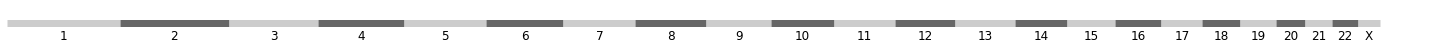

In [121]:
sizes_df = pd.read_table('/home/groups/dpwall/briannac/general_data/reference_genomes/hg38_chromsome_sizes.txt', header=None)
sizes = [int(s.replace(',','')) for s in sizes_df[2]]
starts = [np.sum(sizes[:i]) for i in range(23)] + [3041559849]

def loci_linear_idx(chrom, loci):
    if chrom=='X': chrom=23
    chrom=int(chrom)
    return starts[chrom-1]+loci
linear_idxs = [loci_linear_idx(chrom, loci) for chrom, loci in zip(new_df[new_df.status!='unlocalized'].chrom_pred, new_df[new_df.status!='unlocalized'].start_pred)]

f, ax = plt.subplots(figsize=(20,.8))
for i in range(23):
    if i%2==0: color=(.8,.8,.8)
    else: color=(.4,.4,.4)
    chrom=str(i+1)
    if chrom=='23': chrom='X'
    if chrom=='24': chrom='Y'

    chrom_text=np.mean(starts[i:i+2])
    plt.text(x=chrom_text, y=.4, s=chrom, fontsize=12, ha='center')#, rotation=45, va='top', ha='right')
    plt.hlines(xmin=starts[i], xmax=starts[i+1], y=.5, color=color, linestyle='-', linewidth=7)
plt.xlim(0,starts[-1]+1e8)
ax.axis('off')
plt.ylim(.4,.6)
plt.tight_layout()
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/decoy/chromsome_labels.svg', transparent=True)
plt.show()

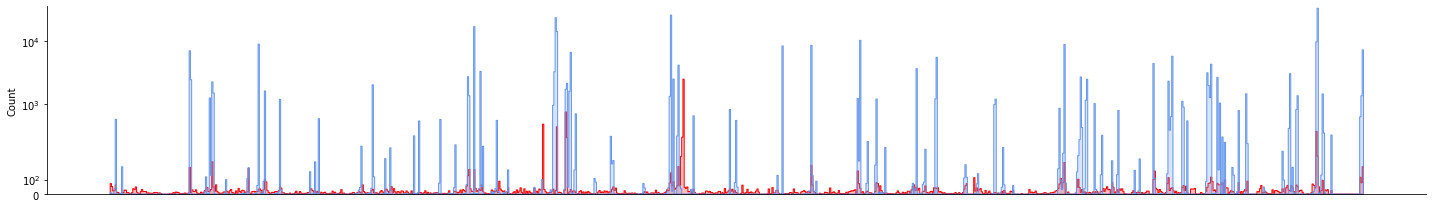

In [122]:
f, ax = plt.subplots(figsize=(20,5))
sns.histplot(x=linear_idxs, hue=new_df[new_df.status!='unlocalized'].status, bins=1000,element='step', kde_kws=dict(linewidth=0), legend=False,
            palette=['cornflowerblue', 'red'])#hist_kws=dict(edgecolor="k", linewidth=0)) #bins=1000)
ax.set_xticks([])
plt.yscale('symlog', linthresh=500)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/decoy/performance_with_chrom_locations.svg', transparent=True)
plt.show()
